# Task X Diffusion
Use a INR model to represent the events in task 1. Please show a side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice that estimates the difference between the two.


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from lpips import LPIPS
import h5py


Convert Tensors into Proper Format
The original and reconstructed images are stored as PyTorch tensors.

Before computation, we detach them from the computational graph and convert them into NumPy arrays if needed.

**Fourier series multiscale method**
Fourier series multiscale method, a concise and efficient analytical approach for multiscale
computation, will be developed out of this series of papers. In the fifth paper, the usual structural analysis
of plates on an elastic foundation is extended to a thorough multiscale analysis for a system of a fourth
order linear differential equation (for transverse displacement of the plate) and a second order linear
differential equation (for the stress function), where general boundary conditions and a wide spectrum of
model parameters are prescribed.  See this research [paper](https://arxiv.org/pdf/2208.11363)

In [26]:
#  Multi-Scale Fourier Features 
class FourierFeatureMapping(nn.Module):
    def __init__(self, num_input_channels=2, mapping_size=512, scales=[5, 10, 20]):
        super().__init__()
        self.Bs = [torch.randn((num_input_channels, mapping_size)) * scale for scale in scales]

    def forward(self, x):
        outputs = []
        for B in self.Bs:
            x_proj = (2.0 * torch.pi * x) @ B.to(x.device)
            outputs.append(torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1))
        return torch.cat(outputs, dim=-1)


**INR Model**
An emerging area within deep learning, implicit neural representation (INR), also known as neural fields, offers a powerful new mechanism and paradigm for processing and representing visual data.In contrast with the dominant big data setting, INR focuses on neural networks which parameterize a field, often in a coordinate-based manner. The most well-known of this class of models is NeRF, which has been wildly successful for 3D modeling, especially for novel view synthesis. INR for 2D images and videos have many compelling properties as well, particularly for visual data compression. [Paper](https://inrv.github.io/)

In [27]:
# INR with Residual Blocks 
class ResidualBlock(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features),
            nn.ReLU(inplace=True),
            nn.Linear(features, features)
        )

    def forward(self, x):
        return x + self.block(x)

class INR(nn.Module):
    def __init__(self, in_features, hidden_features=512, hidden_layers=6, out_features=1):
        super().__init__()
        self.input_layer = nn.Linear(in_features, hidden_features)
        self.res_blocks = nn.ModuleList([ResidualBlock(hidden_features) for _ in range(hidden_layers)])
        self.output_layer = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for block in self.res_blocks:
            x = block(x)
        return self.output_layer(x)


In [28]:


# Coordinate Grid 
def get_mgrid(sidelen):
    coords = torch.stack(torch.meshgrid(torch.linspace(0, 1, sidelen),
                                        torch.linspace(0, 1, sidelen), indexing="ij"), dim=-1)
    return coords.reshape(-1, 2)

#  Load and Normalize Image 
def load_sample_image():
    with h5py.File("/kaggle/input/geniedataset/quark-gluon_data-set_n139306 (1).hdf5", "r") as f:
        ecal = f['X_jets'][0, :, :, 0]
    image = torch.tensor(ecal, dtype=torch.float32)
    image /= image.max() + 1e-8
    return image


In [29]:

#  Discriminator for Adversarial Loss 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(125 * 125, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))


MSE (Mean Squared Error) quantifies the pixel-wise error between the original and reconstructed images.

SSIM (Structural Similarity Index) measures perceived quality by comparing luminance, contrast, and structure.

Values range from 0 to 1, where 1 means identical images.

LPIPS (Learned Perceptual Image Patch Similarity) is a deep-learning-based metric that measures perceptual similarity instead of just pixel-wise differences.

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth
Epoch 0 | MSE: 0.025805 | SSIM: 0.0067 | LPIPS: 0.7970
Epoch 50 | MSE: 0.005094 | SSIM: 0.0551 | LPIPS: 0.4031
Epoch 100 | MSE: 0.002379 | SSIM: 0.1242 | LPIPS: 0.3352
Epoch 150 | MSE: 0.001905 | SSIM: 0.0968 | LPIPS: 0.2955
Epoch 200 | MSE: 0.001358 | SSIM: 0.1672 | LPIPS: 0.2613
Epoch 250 | MSE: 0.000508 | SSIM: 0.4428 | LPIPS: 0.2218
Epoch 300 | MSE: 0.000217 | SSIM: 0.5820 | LPIPS: 0.1239
Epoch 350 | MSE: 0.000058 | SSIM: 0.8206 | LPIPS: 0.0490
Epoch 400 | MSE: 0.000034 | SSIM: 0.8545 | LPIPS: 0.0085
Epoch 450 | MSE: 0.000019 | SSIM: 0.9633 | LPIPS: 0.0035
Epoch 499 | MSE: 0.000005 | SSIM: 0.9912 | LPIPS: 0.0018


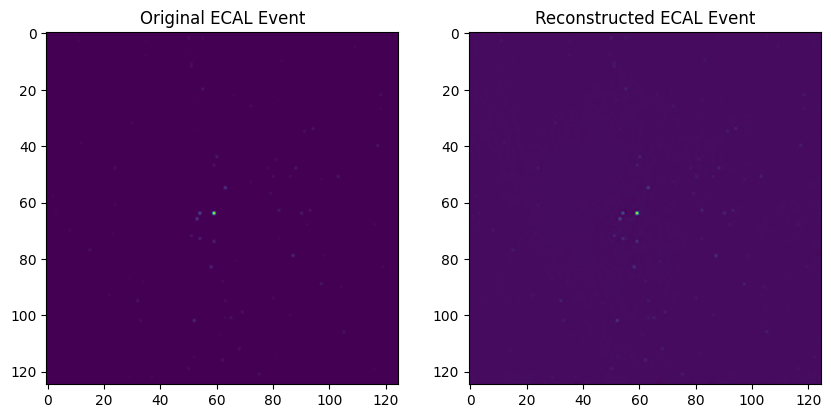

In [30]:


#  Train Function 
def train_inr(image, model, coords, epochs=500, lr=5e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    criterion_mse = nn.MSELoss()
    criterion_lpips = LPIPS(net='vgg')  # More sensitive than AlexNet
    discriminator = Discriminator().to(coords.device)
    optim_D = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))

    image_flat = image.view(-1, 1)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(coords)
        
        mse_loss = criterion_mse(output, image_flat)
        ssim_score = ssim(output.view(125, 125).detach().numpy(), image.numpy(), data_range=1.0)
        lpips_loss = criterion_lpips(output.view(1, 1, 125, 125), image.view(1, 1, 125, 125))

        # Adversarial Loss
        real_preds = discriminator(image.view(1, -1))
        fake_preds = discriminator(output.view(1, -1).detach())
        d_loss = -(torch.log(real_preds + 1e-8) + torch.log(1 - fake_preds + 1e-8)).mean()
        
        fake_preds = discriminator(output.view(1, -1))
        g_loss = -torch.log(fake_preds + 1e-8).mean()

        loss = mse_loss + 0.1 * lpips_loss + 0.01 * (1 - ssim_score) + 0.1 * g_loss

        loss.backward()
        optimizer.step()
        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()
        scheduler.step()

        if epoch % 50 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} | MSE: {mse_loss.item():.6f} | SSIM: {ssim_score:.4f} | LPIPS: {lpips_loss.item():.4f}")

    return model

#  Visualize Results 
def visualize_results(image, model, coords):
    with torch.no_grad():
        reconstructed = model(coords).view(125, 125)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image.numpy(), cmap='viridis')
    axes[0].set_title("Original ECAL Event")
    
    axes[1].imshow(reconstructed.numpy(), cmap='viridis')
    axes[1].set_title("Reconstructed ECAL Event")
    
    plt.show()

#  Run Full Pipeline 
image = load_sample_image()
coords = get_mgrid(125)
ffm = FourierFeatureMapping()
encoded_coords = ffm(coords)

model = INR(in_features=encoded_coords.shape[1], hidden_features=512, hidden_layers=6, out_features=1)
trained_model = train_inr(image, model, encoded_coords)
visualize_results(image, trained_model, encoded_coords)


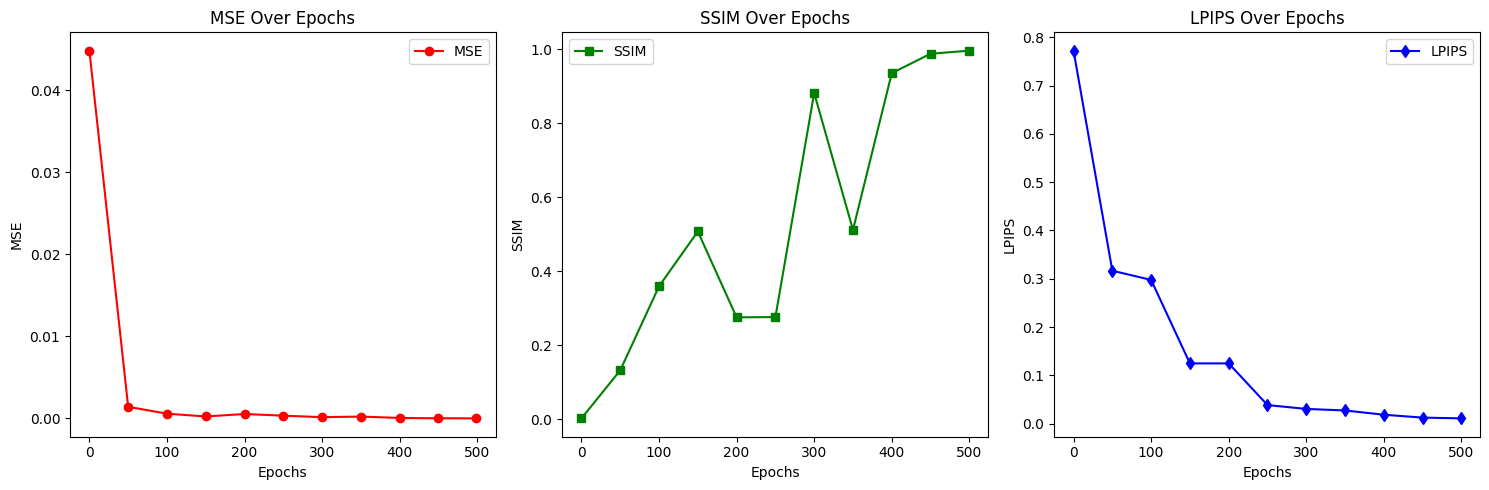

In [31]:
import matplotlib.pyplot as plt

# Sample data (Replace with your actual values)
epochs = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 499]
mse_values = [0.044815, 0.001412, 0.000575, 0.000235, 0.000534, 0.000331, 0.000149, 0.000222, 0.000050, 0.000014, 0.000006]
ssim_values = [0.0020, 0.1319, 0.3592, 0.5076, 0.2752, 0.2760, 0.8821, 0.5118, 0.9358, 0.9883, 0.9965]
lpips_values = [0.7723, 0.3166, 0.2976, 0.1247, 0.1247, 0.0384, 0.0304, 0.0272, 0.0184, 0.0124, 0.0109]

plt.figure(figsize=(15, 5))

# MSE Plot
plt.subplot(1, 3, 1)
plt.plot(epochs, mse_values, marker='o', linestyle='-', color='r', label="MSE")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("MSE Over Epochs")
plt.legend()

# SSIM Plot
plt.subplot(1, 3, 2)
plt.plot(epochs, ssim_values, marker='s', linestyle='-', color='g', label="SSIM")
plt.xlabel("Epochs")
plt.ylabel("SSIM")
plt.title("SSIM Over Epochs")
plt.legend()

# LPIPS Plot
plt.subplot(1, 3, 3)
plt.plot(epochs, lpips_values, marker='d', linestyle='-', color='b', label="LPIPS")
plt.xlabel("Epochs")
plt.ylabel("LPIPS")
plt.title("LPIPS Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()
